## Contents:
* [General overview](#general-overview)
* [Imports and config](#import-config)
* [Data inpsection and preparation](#data-prep)
* [Model training](#model-creation)
* [Model evaluation](#model-evaluation)
* [Create endpoint from model](#endpoint)

## General overview <a class="anchor" id="general-overview"></a>

Our goal is to create an ML model that can predict with high accuracy the angle at which a boat should be heading, given metadata features such as boat speed, wind speed, attack angle and target angle. Rather than performing a regression to predict the angle directly, we will instead create two models for predicting the cosine and sine, respectively. This notebook is concerned with predicting the cosine of boat's angle.

As a counter-candidate model for linear regression, we will create a (non-linear) regression model using Keras. In addition to this, we will use cosine and sine of the angles involved as features, rather than the angles themselves.

**Important findings** after running the experiments below:
1. Minimizing MSE is a better strategy than minimizing MAE;
2. Non-linear regression outperforms linear regression;
3. Wider models outperform deeper models. This is not immediately obvious, but seems to be the case in regression tasks involving other well-known datasets, see for example [here](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
4. The best model is either 2-hidden layers of sizes (256, 128) OR 2-hidden layers of sizes (512, 256).

## Basic imports <a class="anchor" id="import-config"></a>

In [1]:
import pandas as pd
import numpy as np
import io
import time
import json
import sagemaker.amazon.common as smac
import os
import boto3
import re
import sagemaker
from os.path import join
from sklearn.model_selection import train_test_split

## Setup the config

In [2]:
ROLE = sagemaker.get_execution_role()
REGION = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix

BUCKET = 'virtual-regatta-ml'
PREFIX = 'non_linear_keras_sine' # place to upload training files within the bucket
TEST_NAME = 'default'
ENDPOINT_NAME = 'VR-keras-sin-endpoint-' + time.strftime("%Y-%m-%d-%H-%M", time.gmtime())
INSTANCE_TYPE = 'ml.t2.medium'
                                                            

## Load the data <a class="anchor" id="data-prep"></a>

In [3]:
data = pd.read_csv('../all-in-one.csv')
# This column will be predicted using a classifier
data['cos_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.cos(np.deg2rad(x)))
data['sin_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.sin(np.deg2rad(x)))
data = data.drop(columns=['cos_boat_angle','angle_of_attack'])

# The column to predict has to be in last position
df_reordered = data[['boat_speed','cos_attack_angle', 'sin_attack_angle', 'wind_speed','cos_target_angle', 'sin_target_angle', 'sin_boat_angle']]

print(df_reordered.head())


   boat_speed  cos_attack_angle  sin_attack_angle  wind_speed  \
0     7.73236         -0.558392         -0.829577     9.43467   
1     7.73236         -0.558392         -0.829577     9.43467   
2     7.78952         -0.572786         -0.819705     9.59005   
3     7.81913         -0.572786         -0.819705     9.66396   
4     7.81658         -0.572786         -0.819705     9.65759   

   cos_target_angle  sin_target_angle  sin_boat_angle  
0         -0.554636         -0.832093       -0.867056  
1         -0.564295         -0.825573       -0.867056  
2         -0.577277         -0.816548       -0.858796  
3         -0.592192         -0.805797       -0.853061  
4         -0.607512         -0.794311       -0.850423  


In [4]:
dup_columns_check = ['boat_speed', 'cos_attack_angle', 'sin_attack_angle', 'wind_speed', 'sin_boat_angle']
dup_boat_angle = df_reordered[df_reordered.duplicated(dup_columns_check, keep=False)]
print(f'Total duplicate rows based on {dup_columns_check}: {len(dup_boat_angle)}')
dup_boat_angle.head(10)

Total duplicate rows based on ['boat_speed', 'cos_attack_angle', 'sin_attack_angle', 'wind_speed', 'sin_boat_angle']: 379


,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,sin_boat_angle
0,7.73236,-0.558392,-0.829577,9.43467,-0.554636,-0.832093,-0.867056
1,7.73236,-0.558392,-0.829577,9.43467,-0.564295,-0.825573,-0.867056
53,7.67317,-0.481758,-0.876304,9.45885,-0.599954,-0.800035,-0.824675
54,7.67317,-0.481758,-0.876304,9.45885,-0.611783,-0.791026,-0.824675
159,4.99455,0.677019,-0.735966,3.36962,0.246974,-0.969022,-0.956533
160,4.99455,0.677019,-0.735966,3.36962,0.248787,-0.968558,-0.956533
182,6.71103,-0.094576,-0.995518,3.61274,-0.201650,-0.979458,-0.954190
183,6.71103,-0.094576,-0.995518,3.61274,-0.199921,-0.979812,-0.954190
194,5.73604,-0.765839,-0.643032,4.55132,-0.500285,-0.865861,-0.953384
195,5.73604,-0.765839,-0.643032,4.55132,-0.502534,-0.864557,-0.953384


In [5]:
corr = df_reordered.corr()
corr.style.background_gradient()

,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,sin_boat_angle
boat_speed,1.000000,-0.169869,0.372060,0.749770,-0.124149,0.132518,0.104913
cos_attack_angle,-0.169869,1.000000,0.006623,-0.068656,0.684405,-0.215598,-0.236987
sin_attack_angle,0.372060,0.006623,1.000000,0.474577,0.070566,0.223785,0.193376
wind_speed,0.749770,-0.068656,0.474577,1.000000,-0.024937,0.574937,0.531334
cos_target_angle,-0.124149,0.684405,0.070566,-0.024937,1.000000,-0.012991,-0.028158
sin_target_angle,0.132518,-0.215598,0.223785,0.574937,-0.012991,1.000000,0.983153
sin_boat_angle,0.104913,-0.236987,0.193376,0.531334,-0.028158,0.983153,1.000000


In [6]:
df_reordered = df_reordered.drop_duplicates(subset=dup_columns_check)

In [7]:
df_reordered.describe()

,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,sin_boat_angle
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000
mean,6.435845,-0.198043,0.058539,8.401832,-0.244525,-0.068352,-0.071900
std,2.747382,0.559119,0.803129,5.182322,0.619872,0.742675,0.751131
min,0.000000,-0.999884,-1.000000,2.000000,-1.000000,-0.999996,-0.999999
25%,4.396755,-0.701373,-0.762417,4.625820,-0.849687,-0.793188,-0.769946
50%,5.818855,-0.302591,0.514912,6.735055,-0.311420,-0.267974,-0.303275
75%,7.868065,0.200625,0.817129,9.959260,0.193021,0.824016,0.867396
max,14.291300,0.999766,1.000000,21.077130,0.999749,0.999990,1.000000


## Create train-val-test split

In [8]:
def save_train_and_validation_data_to_s3(data) :
    test_col = 'sin_boat_angle'
    y_data = data[test_col]
    X_data = data.drop(columns=[test_col])
    X_data = X_data.to_numpy()
    y_data = y_data.to_numpy()
    
    # 70% training, 15% validation, 15% testing split
    train_X, test_X, train_y, test_y = train_test_split(X_data, y_data, train_size=0.7, random_state=42)
    
    val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, train_size=0.5, random_state=41)

    train_file = 'non_linear_train.data'

    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME, 'train', train_file)).upload_fileobj(f)
    validation_file = 'non_linear_validation.data'
    
    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME,'validation', validation_file)).upload_fileobj(f)
    return train_X, train_y, val_X, val_y, test_X, test_y

## Create a non-linear regression model using keras <a class="anchor" id="model-creation"></a>

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


# Build the model
def wide_keras_model(size_1, size_2):
    model = Sequential()
    model.add(Dense(size_1, input_dim=6, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_1'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(size_2, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_2'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', bias_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  optimizer='adam')
    return model

Using TensorFlow backend.


In [10]:
train_X, train_y, val_X, val_y, test_X, test_y = save_train_and_validation_data_to_s3(df_reordered)
train_y = np.expand_dims(train_y, axis=1)
val_y = np.expand_dims(val_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)
print(f'Number of examples in training data: {len(train_y)}')
print(f'Number of examples in validation data: {len(val_y)}')
print(f'Number of examples in test data: {len(test_y)}')

Number of examples in training data: 2405
Number of examples in validation data: 515
Number of examples in test data: 516


### Use a manual grid search for best architecture using Validation data and EarlyStopping

In [11]:
from keras.callbacks import EarlyStopping
hidden_layer_sizes = [(64, 32), (128, 64), (256, 128), (512, 256)]
models = []
scores = []
callback = EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True,
    verbose=0)

for i, (size_1, size_2) in enumerate(hidden_layer_sizes):
    models.append(wide_keras_model(size_1, size_2))
    models[i].fit(
        train_X,
        train_y,
        epochs=200,
        batch_size=16,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = models[i].evaluate(train_X, train_y, verbose=0)
    val_score = models[i].evaluate(val_X, val_y, verbose=0)
    scores.append(val_score)
    print(f'Scores for hidden layer sizes {size_1} and {size_2}:')
    print(f'training MSE:{training_score:.4f}')
    print(f'validationMSE:{val_score:.4f}')
    print('\n')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Scores for hidden layer sizes 64 and 32:
training MSE:0.0086
validationMSE:0.0089


Scores for hidden layer sizes 128 and 64:
training MSE:0.0065
validationMSE:0.0067


Scores for hidden layer sizes 256 and 128:
training MSE:0.0058
validationMSE:0.0061


Scores for hidden layer sizes 512 and 256:
training MSE:0.0045
validationMSE:0.0048




## Evaluate best model on test data <a class="anchor" id="model-evaluation"></a>

In [12]:
best_idx = np.argmin(scores)
best_sizes = hidden_layer_sizes[best_idx]
best_model = models[best_idx]
best_model.summary()
test_score = best_model.evaluate(test_X, test_y, verbose=0)
print(f'Best performing model is of sizes {best_sizes} for hidden layers')
print(f'Best model MSE on the test set: {test_score:.4f}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 135,169
Trainable params: 135,169
Non-trainable params: 0
_________________________________________________________________
Best performing model is of sizes (512, 256) for hidden layers
Best model MSE on the test set: 0.0050


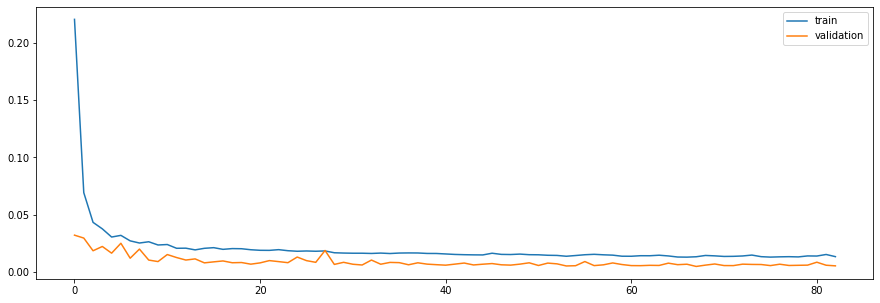

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(best_model.history.history['loss'], label='train')
plt.plot(best_model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### Sanity check using different library

In [14]:
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde

test_pred = best_model.predict(test_X)
absolute_error = np.squeeze(np.absolute(test_pred - test_y))
print(f'TEST MAE: {np.mean(absolute_error):.4f}')
mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {round(mse,4)}, \n")

abs_error = [(-e, i) for i, e in enumerate(absolute_error)]
abs_error.sort()
highest_errors = [
    f'{round(-e,3)}: ({test_pred[i][0]:.3f}, {round(test_y[i][0], 3)})' for e, i in abs_error]
print(f'Top highest absolute value errors on test data: \n {highest_errors[:10]} \n')
print(f'Top lowest absolute value errors on test data: \n {highest_errors[-10:]}')


TEST MAE: 0.0509
Test MSE: 0.005, 

Top highest absolute value errors on test data: 
 ['0.324: (-0.253, -0.577)', '0.298: (-0.279, -0.577)', '0.255: (-0.580, -0.325)', '0.247: (-0.685, -0.438)', '0.235: (-0.757, -0.993)', '0.234: (0.026, 0.261)', '0.232: (0.767, 0.999)', '0.224: (-0.783, -0.559)', '0.202: (-0.804, -0.602)', '0.202: (-0.556, -0.758)'] 

Top lowest absolute value errors on test data: 
 ['0.002: (0.189, 0.191)', '0.002: (-0.919, -0.921)', '0.002: (0.159, 0.157)', '0.001: (0.982, 0.983)', '0.001: (-0.672, -0.673)', '0.001: (-0.923, -0.922)', '0.001: (0.986, 0.985)', '0.001: (-0.405, -0.404)', '0.001: (0.190, 0.191)', '0.0: (-0.928, -0.928)']


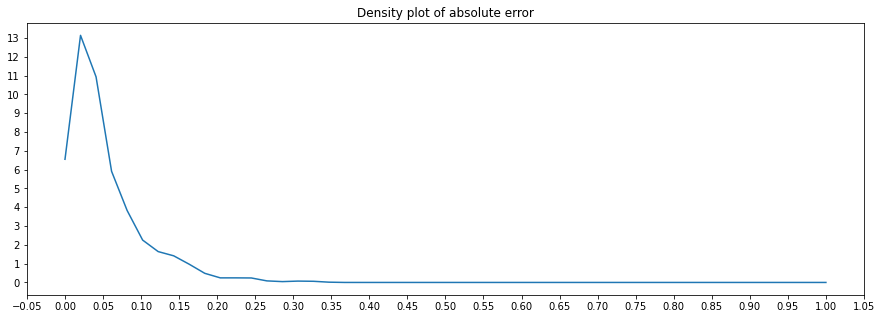

In [15]:
density = gaussian_kde(absolute_error)
xs = np.linspace(0,1,50)
plt.figure(figsize=(15,5))
plt.plot(xs,density(xs))
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=30)
plt.title('Density plot of absolute error')
plt.show()

## Save best model and create an endpoint from it <a class="anchor" id="endpoint"></a>

In [16]:
best_model.save_weights('keras_sine_model/best_model_weights.h5')
model_json = best_model.to_json()
with open("keras_sine_model/best_model.json", "w") as json_file:
    json_file.write(model_json)

In [17]:
import keras
from keras.models import model_from_json

In [18]:
json_file = open('keras_sine_model/best_model.json', 'r')
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('keras_sine_model/best_model_weights.h5')
json_file.close()

In [19]:
!rm -rf export

In [20]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

version_number = '1'
export_dir = 'export/Servo/' + version_number
builder = builder.SavedModelBuilder(export_dir)
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

from keras import backend as K
with K.get_session() as sess:
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


In [21]:
import tarfile

with tarfile.open('keras-sine-model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='keras-sine-model.tar.gz', bucket=BUCKET, key_prefix='keras_sine_model')

In [22]:
!touch train.py

from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + BUCKET + '/keras_sine_model/keras-sine-model.tar.gz',
                                  role = ROLE,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [23]:
%%time
predictor = sagemaker_model.deploy(
    endpoint_name = ENDPOINT_NAME,
    initial_instance_count=1,
    instance_type=INSTANCE_TYPE)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!CPU times: user 492 ms, sys: 29.4 ms, total: 521 ms
Wall time: 7min 33s


### Call the endpoint

In [24]:
import json

runtime = boto3.client('runtime.sagemaker')
payload = json.dumps(test_X.tolist())
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
test_pred = np.array([r for r in result['outputs']['score']['floatVal']])

## Sanity check evaluating the endpoint on test data again

In [25]:
absolute_error = np.absolute(test_pred - np.squeeze(test_y))
print(f'TEST MAE: {np.mean(absolute_error):.4f}')
mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {round(mse,4)}, \n")

TEST MAE: 0.0509
Test MSE: 0.005, 

